# 第6章: 機械学習
https://nlp100.github.io/ja/ch06.html

本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む

## 50. データの入手・整形
[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（`train.txt`），検証データ（`valid.txt`），評価データ（`test.txt`）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．


In [3]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip && unzip NewsAggregatorDataset.zip -d NewsAggregatorDataset && rm NewsAggregatorDataset.zip
# !mv NewsAggregatorDataset ../dataset

data_dir = '../dataset/NewsAggregatorDataset'
# !cat {data_dir}/readme.txt


In [4]:
import os.path as osp
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_table(osp.join(data_dir, 'newsCorpora.csv'), header=None, index_col=0, names=['id', 'title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp'])
df_extracted = df[df['publisher'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]
df_extracted = df_extracted.sample(frac=1)[['category', 'title']] # シャッフル & カテゴリと見出しの抽出

train, test = train_test_split(df_extracted, test_size=0.2, stratify=df_extracted['category'])
valid, test = train_test_split(test, test_size=0.5, stratify=test['category'])

# 保存
train.to_csv('train.txt', sep='\t', header=None, index=None)
valid.to_csv('valid.txt', sep='\t', header=None, index=None)
test.to_csv('test.txt', sep='\t', header=None, index=None)

# カテゴリの事例数
print(f"train:\n{train['category'].value_counts()}")
print(f"valid:\n{valid['category'].value_counts()}")
print(f"test:\n{test['category'].value_counts()}")


train:
b    4502
e    4223
t    1219
m     728
Name: category, dtype: int64
valid:
b    563
e    528
t    152
m     91
Name: category, dtype: int64
test:
b    562
e    528
t    153
m     91
Name: category, dtype: int64


## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ．
なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．


In [5]:
import numpy as np
import texthero as hero
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidfで特徴量を抽出
tfidf = TfidfVectorizer(max_features=2000)
tfidf.fit(hero.clean(train['title']))

# tfidf特徴に変換
train_feature = tfidf.transform(hero.clean(train['title']))
valid_feature = tfidf.transform(hero.clean(valid['title']))
test_feature = tfidf.transform(hero.clean(test['title']))

# 保存
np.savetxt('train.feature.txt', train_feature.toarray())
np.savetxt('valid.feature.txt', valid_feature.toarray())
np.savetxt('test.feature.txt', test_feature.toarray())

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．


In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)

X_train, y_train = train_feature, train['category'].values
X_valid, y_valid = valid_feature, valid['category'].values
X_test, y_test = test_feature, test['category'].values
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．


In [7]:
def predict(X, lr):
    pred = lr.predict(X)
    prob = np.max(lr.predict_proba(X), axis=1)
    return pred, prob

train['predict'], train['probability'] = predict(X_train, lr)
valid['predict'], valid['probability'] = predict(X_valid, lr)
test['predict'], test['probability'] = predict(X_test, lr)
train

,category,title,predict,probability
id,,,,
59954,b,Australia: Missing Malaysia Plane Search Area ...,b,0.759993
207883,b,"UPDATE 1-Nowotny says would prefer ""package"" o...",b,0.979861
124262,e,Ice Cube Jokes That Paul Walker 'Robbed' Him O...,e,0.984214
224928,t,Sprint to pay $7.5 mln in record US settlement...,b,0.673844
203269,m,Omsignal smart shirt that can monitor your wor...,t,0.350268
...,...,...,...,...
308671,b,MARKET EYE-Indian bond yields hit 1-month high...,b,0.982162
35466,b,Tiffany Profit Forecast Trails Estimates as Sp...,b,0.961913
80958,b,UK Manufacturing Growth Cools as Export Demand...,b,0.924518


## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．


In [8]:
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
print(f'train: {train_score}, test: {test_score}')

train: 0.924756371814093, test: 0.8770614692653673


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．


In [9]:
from sklearn.metrics import confusion_matrix

print(f'train confusion matrix:\n {confusion_matrix(y_train, train["predict"])}')
print(f'test confusion matrix:\n {confusion_matrix(y_test, test["predict"])}')

train confusion matrix:
 [[4348   82    7   65]
 [  54 4154    4   11]
 [  91  125  504    8]
 [ 210  140    6  863]]
test confusion matrix:
 [[524  27   2   9]
 [ 19 505   1   3]
 [ 17  21  50   3]
 [ 27  34   1  91]]


## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．


In [10]:
from sklearn.metrics import classification_report
print(f'train classification_report:\n {classification_report(y_train, train["predict"])}')
print(f'test classification_report:\n {classification_report(y_test, test["predict"])}')

train classification_report:
               precision    recall  f1-score   support

           b       0.92      0.97      0.94      4502
           e       0.92      0.98      0.95      4223
           m       0.97      0.69      0.81       728
           t       0.91      0.71      0.80      1219

    accuracy                           0.92     10672
   macro avg       0.93      0.84      0.88     10672
weighted avg       0.93      0.92      0.92     10672

test classification_report:
               precision    recall  f1-score   support

           b       0.89      0.93      0.91       562
           e       0.86      0.96      0.91       528
           m       0.93      0.55      0.69        91
           t       0.86      0.59      0.70       153

    accuracy                           0.88      1334
   macro avg       0.88      0.76      0.80      1334
weighted avg       0.88      0.88      0.87      1334



## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．


In [11]:
category_name = {'b': 'business', 't': 'science and technology', 'e': 'environment', 'm': 'health'}
features = np.array(tfidf.get_feature_names())
for label, coef in zip(lr.classes_, lr.coef_):
    print(f'Category: {category_name[label]}')
    coef = np.argsort(coef)
    best = pd.DataFrame(features[coef[::-1][:10]], columns=['TOP'], index=list(range(1, 11))).T
    worst = pd.DataFrame(features[coef[:10]], columns=['LOW'], index=list(range(1, 11))).T
    print(pd.concat([best, worst], axis=0))


Category: business
         1      2          3     4       5      6        7        8   \
TOP  stocks   bank        fed   ecb    euro  china   dollar  ukraine   
LOW   ebola  aereo  microsoft  star  people  virus  samsung     drug   

            9           10  
TOP  obamacare      profit  
LOW      video  kardashian  
Category: environment
             1      2       3      4      5        6        7      8      9   \
TOP  kardashian  chris   miley  cyrus    kim  beyonce    movie   film   paul   
LOW      update     us  google  china  study       gm  billion  apple  ebola   

       10  
TOP   met  
LOW  data  
Category: health
        1         2      3       4     5        6      7     8           9   \
TOP  ebola       fda  study  cancer  drug     mers  cases   cdc  cigarettes   
LOW     gm  facebook  apple     ceo  bank  climate    buy  deal       sales   

         10  
TOP  health  
LOW  amazon  
Category: science and technology
         1      2         3          4        5 

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．


In [12]:
C_list = [0.0001, 0.01, 0.1, 1, 10, 100, 1000]
result = []

def train(X, y, C=1, seed=42):
    lr = LogisticRegression(C=C, max_iter=10000, random_state=seed)
    lr.fit(X, y)
    return lr

for C in C_list:
    print(C)
    lr = train(X_train, y_train, C=C)
    train_score = lr.score(X_train, y_train)
    valid_score = lr.score(X_valid, y_valid)
    test_score = lr.score(X_test, y_test)
    result += [[C, train_score, valid_score, test_score]]

0.0001
0.01
0.1
1
10
100
1000


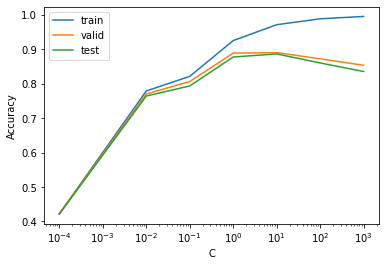

In [13]:
import matplotlib.pyplot as plt
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xlabel('C')
plt.legend()

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．


In [19]:
import scipy
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    "C": scipy.stats.uniform(1e-2, 1e2),
}

In [20]:
lr = LogisticRegression(max_iter=10000, solver='saga')
lr = RandomizedSearchCV(estimator=lr, param_distributions=param_dist)
lr.fit(X_train, y_train)


RandomizedSearchCV(estimator=LogisticRegression(max_iter=10000, solver='saga'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6196476070>})

In [25]:
print(lr.best_params_)
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
print(f'train: {train_score}, test: {test_score}')

{'C': 10.513390927289347}
train: 0.9713268365817092, test: 0.8860569715142429
